In [1]:
import numpy as np
import pyemma
import matplotlib.pyplot as plt
import pyemma.plots as mplt
import h5py
from MSMRD.trajectories import allTrajs_inner
%matplotlib inline

In [2]:
def filter(f, stride):
    for i, line in enumerate(f):
        if (not i%stride):
            yield line

In [3]:
# Create a child class from the main class in trajectories_class.py
class asym2Dtraj(allTrajs_inner):
    def __init__(self, centers=None, Trajs=None):
        super(asym2Dtraj, self).__init__(Trajs)
        if centers == None:
            centers = []
        self.centers = centers
    
    # Overwrite getState function in parent class
    def getState(self, coord, prevst):
        cen2coord = self.centers - coord
        norm = np.asarray(map(lambda x: np.linalg.norm(x), cen2coord))
        index = np.where(norm == norm.min())[0][0]
        if (norm[index] <= 0.2 ):
            return index
        # Old way of doing it
        #for i in range(len(self.centers)):
        #    cen = np.asarray(self.centers[i])
        #    dist = np.linalg.norm(coord - cen)
        #    if dist <= 0.2:
        #        state = i
        #        return state
        
        # if no new state found, return previous state
        return prevst
    
    # Overwrite getMilestones function
    def getMilestones(self):
        self.milestones = self.centers
    
    # Overwrite getRegionMap function
    def getRegionMap(self):
        for i in range(len(self.centers)):
            statename = 'State 1 ' + str(i)
            self.refionMap[i] = statename

In [32]:
numfiles = 12
# Extract trajectories from file using asym2Dtraj class
fname = '../data/asym2D/2DasymTrajsLong_bigR_bigT_'
minima = [[0.0,0.0], [1.0,0.0] , [1.1, 1.0], [-0.1,0.9], [-1.3,0.8], \
                       [-1.0,-0.2], [-0.6,-1.0], [0.9,-0.8], [0.2,-1.5]]
alltrajs = asym2Dtraj(minima, []) # define allTrajs object
#alltrajs = allTrajs_inner([])
dimension = 2
for number in range(numfiles):
    f = h5py.File(fname + str(number)+'.h5', 'r')
    data = np.array(f['traj'], dtype=float)
    f.close()
    traj = data[:,1:dimension+1]
    alltrajs.Trajs.append(traj)

In [33]:
# Calculate discrete trajectories and make sure it is clean (no "None" elements)
dtrajs = alltrajs.getdTrajsclean()
# Obtain centers of each state and save
centersdict = alltrajs.getMilestones()
centers = alltrajs.getMilestonesArray()

In [34]:
# Obtained implied time scales using pyemma
its = pyemma.msm.its(dtrajs, lags = 1000)

(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.]),
 <a list of 7 Text yticklabel objects>)

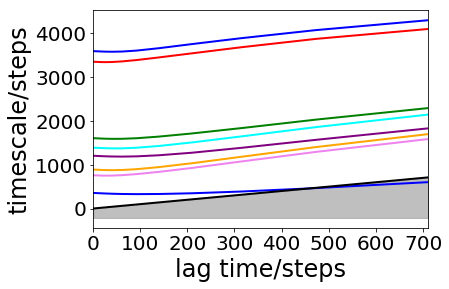

In [35]:
# Plot implied time scales
mplt.plot_implied_timescales(its, ylog=False, units='steps', linewidth=2, dt=1)
plt.ylabel(r"timescale/steps", fontsize = 24)
plt.xlabel(r"lag time/steps", fontsize = 24)
#plt.xlim(0,900)
#plt.ylim(0,900)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

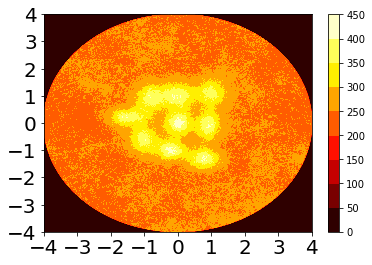

In [36]:
MSMradius = 4.0
X = np.arange(-MSMradius, MSMradius, 0.01)
Y = np.arange(-MSMradius, MSMradius, 0.01)
Zfull = np.zeros([X.shape[0]-1, X.shape[0]-1])
for traj in alltrajs.Trajs:
    hist = np.histogram2d(traj[:,0], traj[:,1], bins = [X, Y], normed=False)
    Zfull += hist[0]
extent = [X[0], X[-1], Y[0], Y[-1]]
cp = plt.contourf(Zfull, 10, cmap=plt.cm.hot, extent=extent)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.colorbar()

In [37]:
# Choose lag time and obtain MSM "M" for our milestones
msm_lag = 200
M = pyemma.msm.estimate_markov_model(dtrajs, msm_lag, reversible=True)

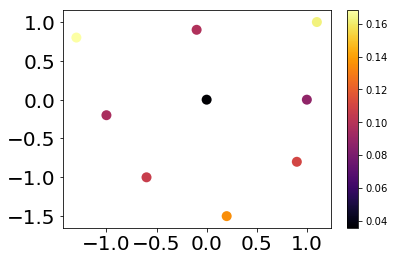

In [38]:
# Plot states and color them according to their weight in a given eigenmode
eigenmode = 0 # 0 = stationary distribution
vectors = M.eigenvectors_left()
value = M.eigenvalues()
#print M.timescales()[:10] 
#print -msm_lag/np.log(value[1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sc = plt.scatter(centers[:,0], centers[:,1], c=vectors[eigenmode][:], cmap=plt.cm.inferno, linewidths = 0, s=100)
plt.colorbar()